<a href="https://colab.research.google.com/github/PurpleChina23/Trading-Card-Grading-System-Centering-Assessment-/blob/main/centering_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import random
import scipy as sp
import numpy as np
import scipy.ndimage as nd
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage import data, exposure
from skimage.feature import hog
from skimage.io import imread, imshow
from PIL import Image, ImageDraw
import numpy
from numpy import linalg as LA
from skimage import transform
from skimage.io import imread, imshow
from scipy.stats import linregress
from sympy import solve, symbols
import itertools

##Load image

In [ ]:
def load_img(file_name):
    img_gray = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    img_gray = img_gray.astype('uint8')
    return img_gray

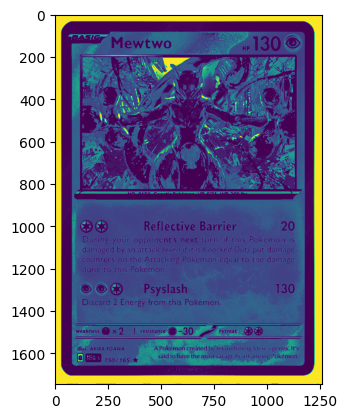

In [ ]:
template = load_img('/content/drive/MyDrive/Pokemon/perfect sample card.png')
plt.imshow(template)


##Homography

In [ ]:
def canny_edge_detector(image, low_threshold, high_threshold):

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    gradient_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude and direction
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * (180 / np.pi)

    # Non-maximum suppression
    non_max_suppressed = cv2.Canny(blurred_image, low_threshold, high_threshold)

    # Edge tracking by hysteresis
    edge_map = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edge_map

Find Contours

In [ ]:
def find_conners(edge_template):
    contours, hierarchy = cv2.findContours(image=edge_template, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    contour_img =  np.zeros(edge_template.shape, dtype=np.uint8)

    cv2.drawContours(contour_img, contours, -1, (255), 2)
    fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(25, 5))

    ax1.imshow(contour_img, cmap = 'gray')

    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

    outter_boarder =  np.zeros(edge_template.shape, dtype=np.uint8)
    inner_boarder =  np.zeros(edge_template.shape, dtype=np.uint8)

    outter_contours = compute_contour(edge_template)

    outter_sorted_contours = sorted(outter_contours, key=lambda x: cv2.contourArea(x), reverse=True)

    outter_contour = outter_sorted_contours[0]

    inner_contour = np.vstack(contours[7:1000])

    cv2.drawContours(outter_boarder, outter_contour, -1, (255), 2)
    cv2.drawContours(inner_boarder, inner_contour, -1, (255), 2)

    ax2.imshow(outter_boarder, cmap = 'gray')
    ax3.imshow(inner_boarder, cmap = 'gray')

    outter_bounding_rectangle =  np.zeros(edge_template.shape, dtype=np.uint8)

    inner_bounding_rectangle =  np.zeros(edge_template.shape, dtype=np.uint8)

    x_o,y_o,w_o,h_o = cv2.boundingRect(outter_contour)
    cv2.rectangle(outter_bounding_rectangle,(x_o,y_o),(x_o+w_o,y_o+h_o),(255),2)

    x_i,y_i,w_i,h_i = cv2.boundingRect(inner_contour)
    cv2.rectangle(inner_bounding_rectangle,(x_i,y_i),(x_i+w_i,y_i+h_i),(255),2)


    ax4.imshow(outter_bounding_rectangle, cmap = 'gray')
    ax5.imshow(inner_bounding_rectangle, cmap = 'gray')

    return x_o,y_o,w_o,h_o,x_i,y_i,w_i,h_i

In [ ]:
def centering_ratio(x_o,y_o,w_o,h_o,x_i,y_i,w_i,h_i):
    inner_center = (x_i+w_i/2, y_i+h_i/2)
    outter_center = (x_o+w_o/2, y_o+h_o/2)

    print(inner_center)
    print(outter_center)

    x = (w_o - w_i)/2
    y = (h_o - h_i)/2

    dx = outter_center[0] - inner_center[0]
    dy = outter_center[1] - inner_center[1]

    if 0.7< (x-dx)/(x+dx) < 1.4 and 0.7< (y-dy)/(y+dy) < 1.4:
      print(f"psa 10 with x centering ratio: {(x-dx)/(x+dx)} and x centering ratio:{(y-dy)/(y+dy)}")
    else:
      print("not psa 10")

(622.5, 872.0)
(627.5, 870.5)
psa 10 with x centering ratio: 0.7777777777777778 and x centering ratio:1.065217391304348


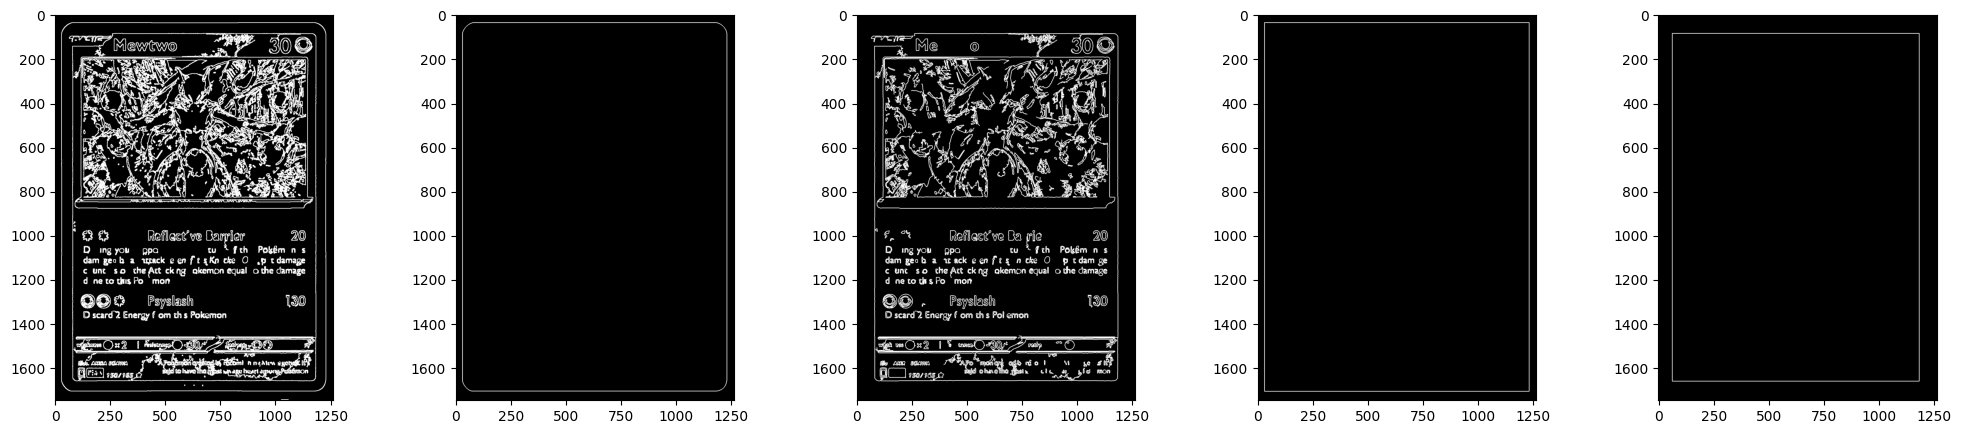

In [ ]:
low_threshold, high_threshold = 0, 255
edge_template = canny_edge_detector(template, low_threshold, high_threshold)
x_o,y_o,w_o,h_o,x_i,y_i,w_i,h_i = find_conners(edge_template)
centering_ratio(x_o,y_o,w_o,h_o,x_i,y_i,w_i,h_i)

##Homography

In [ ]:
def homography(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    dst = cv2.warpPerspective(image, M, (template.shape[1], template.shape[0]))
    plt.subplot(121),plt.imshow(image, cmap='gray'),plt.title('Input')
    dst = cv2.flip(dst, 0)
    plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title('Output')
    plt.show()
    return dst


In [ ]:
def compute_contour(edge_img):
    # Find initial contours in the edge-detected image
    contours, _ = cv2.findContours(image=edge_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    # Create a blank image for drawing convex hulls
    contour_hull = np.zeros(edge_img.shape, dtype=np.uint8)

    # Compute and draw convex hulls for each contour
    for contour in contours:
        convex_hull = cv2.convexHull(contour)
        cv2.drawContours(contour_hull, [convex_hull], -1, 255, -1)

    # Create a blank image for the outermost contours
    contour_img = np.zeros(contour_hull.shape, dtype=np.uint8)

    # Find outermost contours in the hull image
    outer_contours, _ = cv2.findContours(image=contour_hull, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    return outer_contours

In [ ]:
def find_intersection(rho1, theta1, rho2, theta2):
    """Find the intersection of two lines given in polar coordinates."""
    # Calculate the coefficients of the lines in the form of Ax + By = C
    A1 = np.cos(theta1)
    B1 = np.sin(theta1)
    C1 = rho1
    A2 = np.cos(theta2)
    B2 = np.sin(theta2)
    C2 = rho2

    # Solve the system of linear equations
    determinant = A1 * B2 - A2 * B1

    if determinant == 0:
        # Lines are parallel
        return None
    else:
        x = int((B2 * C1 - B1 * C2) / determinant)
        y = int((A1 * C2 - A2 * C1) / determinant)
        return (x, y)

In [ ]:
def intersections(contour_img, outter_contour):
    new = np.zeros(contour_img.shape, dtype=np.uint8)
    cv2.drawContours(new, outter_contour, -1, (255), 1)
    plt.subplot(1, 2, 1)
    plt.imshow(new, cmap='gray')

    threshold = 0
    lines = cv2.HoughLines(new, 1, np.pi / 180, threshold)\

    while lines.shape[0] != 4:
        lines = cv2.HoughLines(new, 1, np.pi / 180, threshold)
        threshold += 50

    intersections = []

    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            rho1, theta1 = lines[i][0]
            rho2, theta2 = lines[j][0]
            intersection = find_intersection(rho1, theta1, rho2, theta2)
            if intersection is not None and 0 < intersection[1] < contour_img.shape[0] and 0 < intersection[0] < contour_img.shape[1] :
                intersections.append(intersection)

    for line in lines:
        rho, theta = line[0]
        # Convert polar coordinates to Cartesian coordinates
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
        cv2.line(new, (x1, y1), (x2, y2), (255), 2)
    plt.subplot(1, 2, 2)
    plt.imshow(new, cmap='gray')
    plt.show()
    return intersections

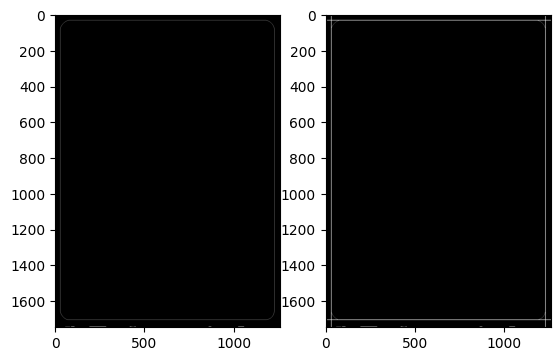

[[  29. 1706.]
 [  29.   34.]
 [1225. 1706.]
 [1225.   34.]]


In [ ]:
low_threshold, high_threshold = 50, 200
edge_template = canny_edge_detector(template, low_threshold, high_threshold)
template_outter_contour = compute_contour(edge_template)
ins_template = np.float32(np.array(intersections(edge_template, template_outter_contour)))
print(ins_template)

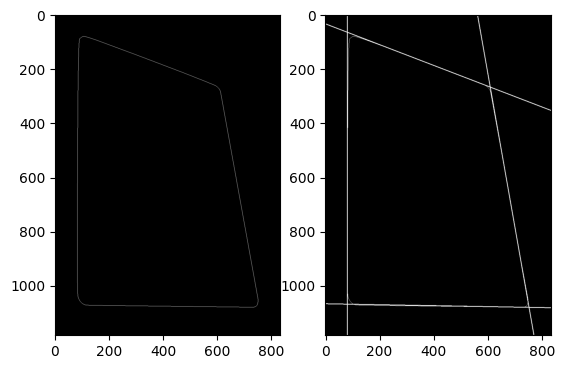

[[  82.   66.]
 [  82. 1070.]
 [ 610.  269.]
 [ 753. 1082.]]


In [ ]:
test = load_img('/content/drive/MyDrive/Pokemon/test.jpg')
low_threshold, high_threshold = 50, 200
edge_test = canny_edge_detector(test, low_threshold, high_threshold)
outter_contour = compute_contour(edge_test)
ins = np.float32(np.array(intersections(edge_test, outter_contour)))
print(ins)

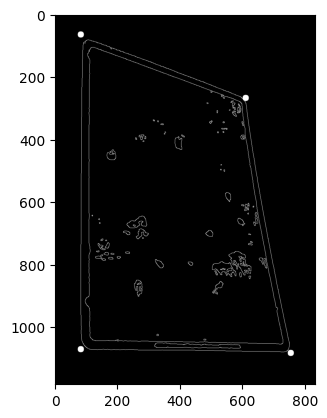

In [ ]:
points_to_circle = [(82, 65), (82, 1072), (609, 268), (753, 1084)]
new = edge_test.copy()
for point in points_to_circle:
    cv2.circle(new, point, 10, (255), -1)
plt.imshow(new, cmap='gray')

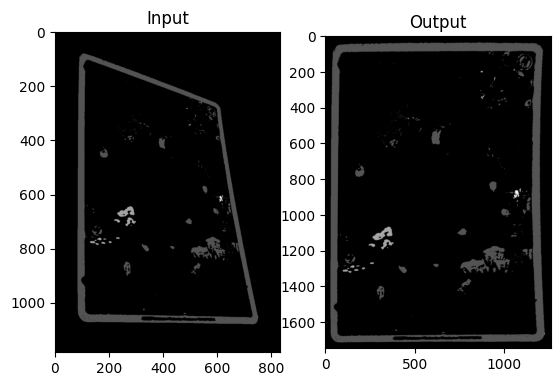

In [ ]:
result = homography(test, ins, ins_template)

(629.0, 878.0)
(629.0, 878.0)


ZeroDivisionError: float division by zero

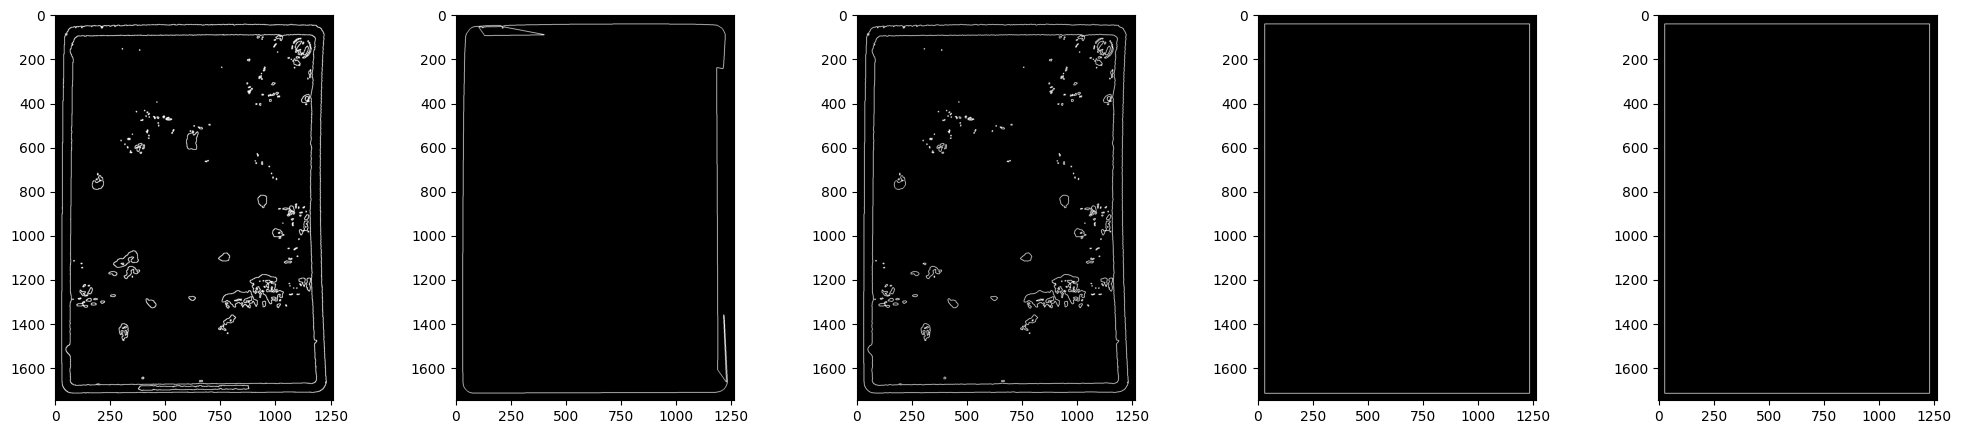

In [ ]:
low_threshold, high_threshold = 50,150
edge_result = canny_edge_detector(result, low_threshold, high_threshold)
x_o,y_o,w_o,h_o,x_i,y_i,w_i,h_i = find_conners(edge_result)
centering_ratio(x_o,y_o,w_o,h_o,x_i,y_i,w_i,h_i)